In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
#import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [2]:
#!pip install scikit-image
#!pip3 install torch torchvision torchaudio
#!pip install varname
#!pip install keras
#!pip install tensorflow

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#feature image path
feature_img_path = "E:/Grss_data/Track1/train/images/10.tif"
# Load the feature tif image with multibands
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()
#check if the image is loaded
if feature_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(feature_img.shape))

#load the label image
label_img_path = "E:/Grss_data/Track1/train/labels/10.png"
#load the label image
with rasterio.open(label_img_path) as src:
    label_img = src.read()
#check if the image is loaded
if label_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(label_img.shape))


Feature image size: (6, 512, 512)
Feature image size: (1, 512, 512)


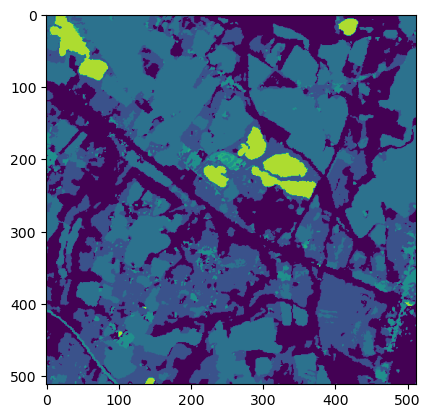

In [6]:
#display the image
plt.imshow(feature_img[4])

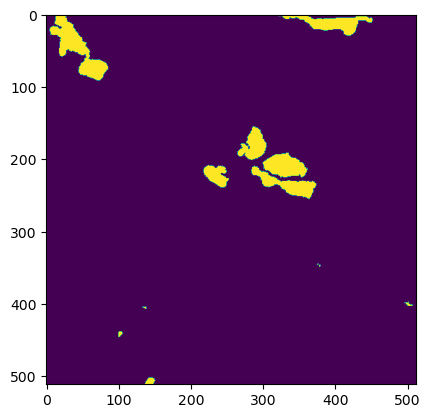

In [7]:
#display the label image
plt.imshow(label_img[0])

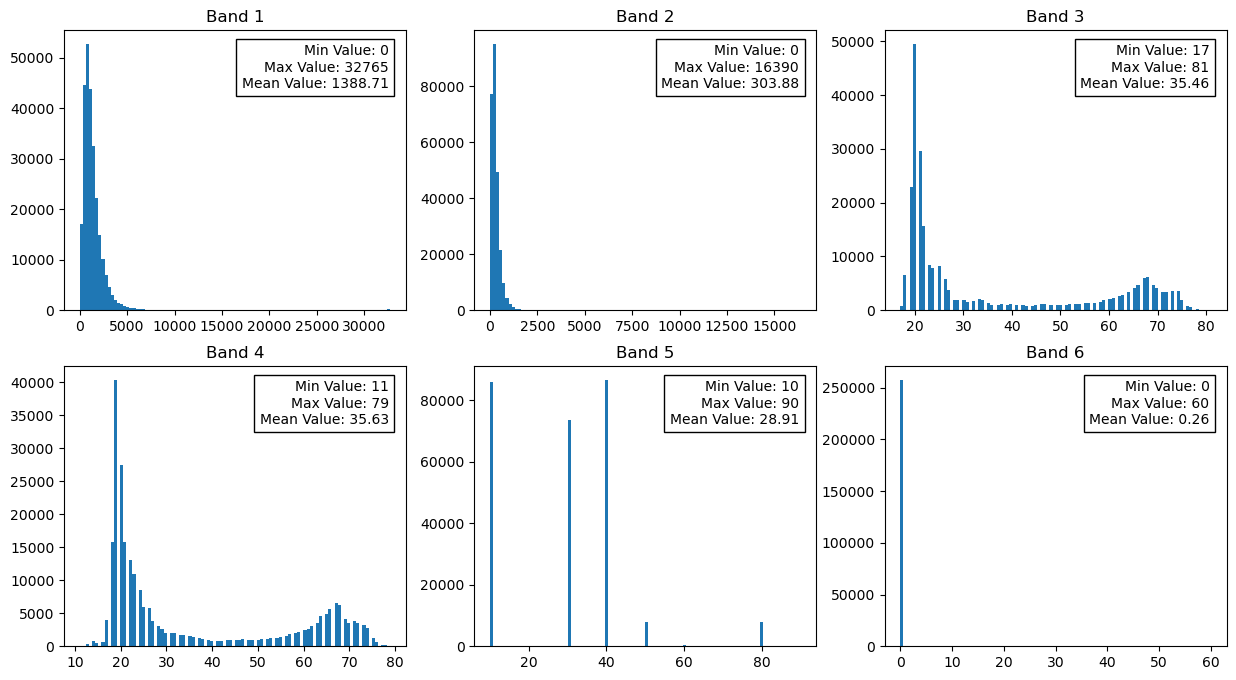

In [8]:
#plot the distribution of the features image.
plt.figure(figsize=(15,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(feature_img[i].ravel(), bins=100)
    plt.title("Band {}".format(i+1))
    plt.text(0.95, 0.95, "Min Value: {}".format(np.min(feature_img[i]))+'\n'+"Max Value: {}".format(np.max(feature_img[i]))+'\n'+"Mean Value: {}".format(round(np.mean(feature_img[i]),2)), ha='right', va='top', transform=plt.gca().transAxes,bbox=dict(facecolor = 'none',edgecolor = 'black'))

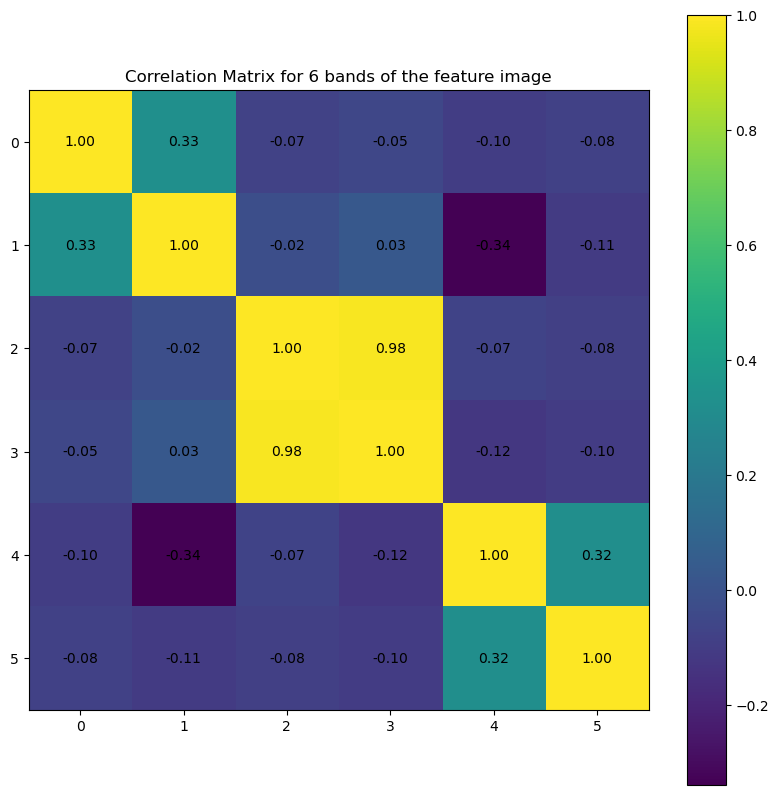

In [9]:
# Calculate the correlation matrix
corr_matrix = np.corrcoef(feature_img.reshape(6, -1), rowvar=True)

# Set up the figure
plt.figure(figsize=(10, 10))

# Display the correlation matrix
cax = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(cax)

# Add title
plt.title("Correlation Matrix for 6 bands of the feature image")

# Adding the correlation values as text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Show the plot
plt.show()

In [10]:
feature_img

array([[[1005, 1239,  892, ..., 3331, 2943, 1682],
        [ 804, 1069,  804, ..., 2365, 2943, 3124],
        [1193,  776,  504, ..., 1549, 3702, 5603],
        ...,
        [ 821,  598,  355, ..., 1666, 1100,  711],
        [ 920, 1179,  632, ..., 1494, 1014,  306],
        [ 666,  755, 1046, ..., 2541, 1308,  306]],

       [[  96,   74,  135, ...,  511,  496,   96],
        [  71,   38,   64, ...,  330,  496,  389],
        [ 200,  131,  107, ...,  115,  362,  402],
        ...,
        [ 322,  322,   64, ...,  280,  204,  143],
        [ 353,  493,  199, ...,  235,  156,  209],
        [ 246,  373,  464, ...,  286,  130,  209]],

       [[  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        ...,
        [  73,   73,   73, ...,   45,   45,   45],
        [  73,   73,   74, ...,   45,   45,   45],
        [  73,   74,   74, ...,   45,   45,   45]],

       [[  18,   18,   18, ...,   18,

In [11]:
#re-orgnize the feature image, so that the image can be used for training
feature_img = np.moveaxis(feature_img, 0, -1)
feature_img = feature_img.reshape(-1, 6)
label_img = label_img.reshape(-1)

In [12]:
feature_img

array([[1005,   96,   19,   18,   30,    0],
       [1239,   74,   19,   18,   30,    0],
       [ 892,  135,   19,   18,   30,    0],
       ...,
       [2541,  286,   45,   39,   10,    0],
       [1308,  130,   45,   40,   10,    0],
       [ 306,  209,   45,   41,   30,    0]], dtype=int16)

In [13]:
scaler = StandardScaler()
scale = scaler.fit_transform(feature_img) 
scale

array([[-0.25982539, -0.81193389, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       [-0.1013758 , -0.89786238, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       [-0.33634164, -0.65960612, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       ...,
       [ 0.78025395, -0.06982424,  0.4752737 ,  0.16660268, -1.19403488,
        -0.10698867],
       [-0.05465349, -0.67913532,  0.4752737 ,  0.21606768, -1.19403488,
        -0.10698867],
       [-0.73314274, -0.37057394,  0.4752737 ,  0.26553269,  0.06898211,
        -0.10698867]])

In [14]:
label_img

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [15]:
#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(feature_img, label_img, test_size=0.2, random_state=42)
#check the shape of the training and testing data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(209715, 6) (209715,)
(52429, 6) (52429,)


In [16]:
#use the random forest classifier to train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [20]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [19]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [2,3,4, 5, 6, 7, 8],
#     'criterion': ['gini', 'entropy']
# }

In [20]:
# # Create a GridSearchCV object
# CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

# # Fit the model
# CV_clf.fit(X_train, y_train)

In [21]:
# # Print the best parameters and the best score
# print("Best Parameters:", CV_clf.best_params_)
# print("Best Score:", CV_clf.best_score_)

In [22]:
#read all test images
feature_img_folder = "E:/Grss_data/Track1/train/images/"
label_img_folder = "E:/Grss_data/Track1/train/labels/"

In [23]:
def read_all_image(img_folder):
#read all images in the folder
    feature_img_list = []
    for filename in os.listdir(img_folder):
        if filename.endswith(".tif"):
            feature_img_list.append(img_folder+filename)
    return feature_img_list

In [24]:
feature_img_list = read_all_image(feature_img_folder)

In [25]:

test_feature_img = np.empty((0,6))
test_label_img = np.empty((0))
for feature_img_path in feature_img_list:
    #print(feature_img_path)
    feature_img = rasterio.open(feature_img_path)
    feature_img = feature_img.read()
    feature_img = np.moveaxis(feature_img, 0, -1)
    feature_img = feature_img.reshape(-1, 6)
    
    scaler = StandardScaler()
    feature_img_scale = scaler.fit_transform(feature_img) 
    
    
    test_feature_img=+feature_img_scale
    #
    label_img_path = label_img_folder+feature_img_path.split('/')[-1].split('.')[0]+'.png'
    label_img = rasterio.open(label_img_path)
    label_img = label_img.read()
    label_img = label_img.reshape(-1)
    test_label_img=+label_img

In [26]:
test_feature_img

array([[-0.16364449,  0.27672296, -0.34043285, -0.63754885, -1.42007593,
        -0.25966993],
       [-0.16364449,  0.27672296, -0.34043285, -0.63754885, -1.42007593,
        -0.25966993],
       [-0.48800907,  0.59212581, -0.23304356, -0.63754885, -1.42007593,
        -0.25966993],
       ...,
       [ 0.40903746, -0.43468569, -0.44782213, -0.44000896,  0.22535454,
        -0.25966993],
       [ 0.357822  , -0.12979627, -0.44782213, -0.44000896,  0.22535454,
        -0.25966993],
       [ 0.57781568,  0.3660871 , -0.44782213, -0.44000896,  0.22535454,
        -0.25966993]])

In [27]:
#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(test_feature_img, test_label_img, test_size=0.2, random_state=42)
#check the shape of the training and testing data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(209715, 6) (209715,)
(52429, 6) (52429,)


In [28]:
#create a logistic regression model
#add timer to check the time
import time

from sklearn.linear_model import LogisticRegression


In [29]:
def classification(method):
  start_time = time.time()
  #logisticRegr = method
  method.fit(X_train, y_train)
  end_time = time.time()
  # get the execution time
  elapsed_time = end_time - start_time
  print('Execution time:', elapsed_time, 'seconds')
  y_pred = method.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  #print f1 score
  from sklearn.metrics import f1_score
  print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
  #print precision score
  from sklearn.metrics import precision_score
  print("Precision score:", precision_score(y_test, y_pred, average='weighted'))
  #print recall score
  from sklearn.metrics import recall_score
  print("Recall score:", recall_score(y_test, y_pred, average='weighted'))
  return elapsed_time, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'),method

In [30]:
#run_time, accuracy, F1,precision,recall = logistic_re()
run_time, accuracy, F1,precision,recall, logisticRegr = classification(LogisticRegression(solver = 'lbfgs', multi_class='multinomial', max_iter=1000))

Execution time: 0.5774545669555664 seconds
Accuracy: 0.9420740429914742
F1 score: 0.9354451825236388
Precision score: 0.9443282796236346
Recall score: 0.9420740429914742


In [31]:
#create a dataframe to store the result
import pandas as pd
result = pd.DataFrame(columns=['Method', 'Run Time', 'Accuracy', 'F1', 'Precision', 'Recall'])
result.loc[0] = ['Logistic Regression', run_time, accuracy, F1,precision,recall]

In [32]:
#create a decision tree model
from sklearn import tree
run_time, accuracy, F1,precision,recall, decisiontree = classification(tree.DecisionTreeClassifier())

Execution time: 0.7789154052734375 seconds
Accuracy: 0.9379160388334701
F1 score: 0.9379367512793874
Precision score: 0.9379576149131557
Recall score: 0.9379160388334701


In [33]:
result.loc[1] = ['Decision Tree', run_time, accuracy, F1,precision,recall]

In [34]:
#create a random forest model
from sklearn.ensemble import RandomForestClassifier
run_time, accuracy, F1,precision,recall , randomforest= classification(RandomForestClassifier())

Execution time: 27.120872735977173 seconds
Accuracy: 0.9560739285509928
F1 score: 0.9539300649136815
Precision score: 0.9549879494168757
Recall score: 0.9560739285509928


In [35]:
result.loc[2] = ['Random Forest', run_time, accuracy, F1,precision,recall]

In [36]:
#create a support vector machine model
from sklearn import svm
run_time, accuracy, F1,precision,recall,svmothed = classification(svm.SVC())

Execution time: 2090.1482694149017 seconds
Accuracy: 0.9524118331457782
F1 score: 0.9481774286972693
Precision score: 0.9540090290315981
Recall score: 0.9524118331457782


In [37]:
result.loc[3] = ['Support Vector Machine', run_time, accuracy, F1,precision,recall]

In [38]:
#create k-nearest neighbors model
from sklearn.neighbors import KNeighborsClassifier
run_time, accuracy, F1,precision,recall,kneighbors = classification(KNeighborsClassifier())

Execution time: 0.45677852630615234 seconds
Accuracy: 0.9516870434301627
F1 score: 0.9492912395740242
Precision score: 0.9501312806360723
Recall score: 0.9516870434301627


In [39]:
result.loc[4] = ['K-Nearest Neighbors', run_time, accuracy, F1,precision,recall]

In [40]:
#create a neural network model
from sklearn.neural_network import MLPClassifier
run_time, accuracy, F1,precision,recall ,neuralnetwork= classification(MLPClassifier())

Execution time: 54.94496464729309 seconds
Accuracy: 0.9552728451811021
F1 score: 0.9522618392313614
Precision score: 0.9551973333710333
Recall score: 0.9552728451811021


In [41]:
result.loc[5] = ['Neural Network', run_time, accuracy, F1,precision,recall]

In [42]:
#create a naive bayes model
from sklearn.naive_bayes import GaussianNB
run_time, accuracy, F1,precision,recall,naivebayes = classification(GaussianNB())

Execution time: 0.06283187866210938 seconds
Accuracy: 0.9508096664059967
F1 score: 0.9465923699701232
Precision score: 0.9516628914064067
Recall score: 0.9508096664059967


In [43]:
result.loc[6] = ['Naive Bayes', run_time, accuracy, F1,precision,recall]

In [44]:
#!pip install xgboost

In [45]:
#create a xbgoost model
from xgboost import XGBClassifier
run_time, accuracy, F1,precision,recall,xgboostmethod = classification(XGBClassifier())


Execution time: 0.7973966598510742 seconds
Accuracy: 0.9575044345686547
F1 score: 0.9547782751997044
Precision score: 0.9575267401730374
Recall score: 0.9575044345686547


In [46]:
result.loc[7] = ['XGBoost', run_time, accuracy, F1,precision,recall]

In [47]:
result

,Method,Run Time,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.577455,0.942074,0.935445,0.944328,0.942074
1,Decision Tree,0.778915,0.937916,0.937937,0.937958,0.937916
2,Random Forest,27.120873,0.956074,0.953930,0.954988,0.956074
3,Support Vector Machine,2090.148269,0.952412,0.948177,0.954009,0.952412
4,K-Nearest Neighbors,0.456779,0.951687,0.949291,0.950131,0.951687
5,Neural Network,54.944965,0.955273,0.952262,0.955197,0.955273
6,Naive Bayes,0.062832,0.950810,0.946592,0.951663,0.950810
7,XGBoost,0.797397,0.957504,0.954778,0.957527,0.957504


In [48]:
#save the result to a csv file in track1 folder
result.to_csv('Track1 result/result.csv',index=False)


In [49]:
#plot the result in a bar chart in one chart including  accuracy, F1, precision and recall using plotly
import plotly.graph_objects as go
fig = go.Figure(data=[
    #go.Bar(name='Run Time', x=result['Method'], y=result['Run Time']),
    go.Bar(name='Accuracy', x=result['Method'], y=result['Accuracy']),
    go.Bar(name='F1', x=result['Method'], y=result['F1']),
    go.Bar(name='Precision', x=result['Method'], y=result['Precision']),
    go.Bar(name='Recall', x=result['Method'], y=result['Recall'])
])
# Change the bar mode
fig.update_layout(barmode='group')
#set y axis range
fig.update_yaxes(range=[0.9, 1])
#set fig size
fig.update_layout(
    autosize=False,
    width=800,
    height=600,)
fig.show()




In [50]:
#save the html file to figures folder
fig.write_html("figures/comparsion1.html")

In [51]:
#save the plot as png file
fig.write_image("figures/comparsion1.png")

In [52]:
#plot run time in a bar chart
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Bar(name='Run Time', x=result['Method'], y=result['Run Time']),
])
# Change the bar mode
fig.update_layout(barmode='group')
#set y as log scale
fig.update_yaxes(type="log")
#set fig size
fig.update_layout(
    autosize=False,
    width=800,
    height=600,)
#set title
fig.update_layout(title_text='Run Time')
#add text to y axis
fig.update_yaxes(title_text='Run Time (seconds)')
fig.show()

In [53]:
#save the html file to figures folder
fig.write_html("figures/comparsion2.html")

In [54]:
#save the plot as png file
fig.write_image("figures/comparsion2.png")

In [55]:
#random pick 1 image for demosntration
feature_img_path = "E:/Grss_data/Track1/train/images/100.tif"
# Load the feature tif image with multibands
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()
#check if the image is loaded
if feature_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(feature_img.shape))


Feature image size: (6, 512, 512)


In [56]:
#load the label image
label_img_path = "E:/Grss_data/Track1/train/labels/100.png"
#load the label image
with rasterio.open(label_img_path) as src:
    label_img = src.read()
#check if the image is loaded
if label_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(label_img.shape))
    

Feature image size: (1, 512, 512)


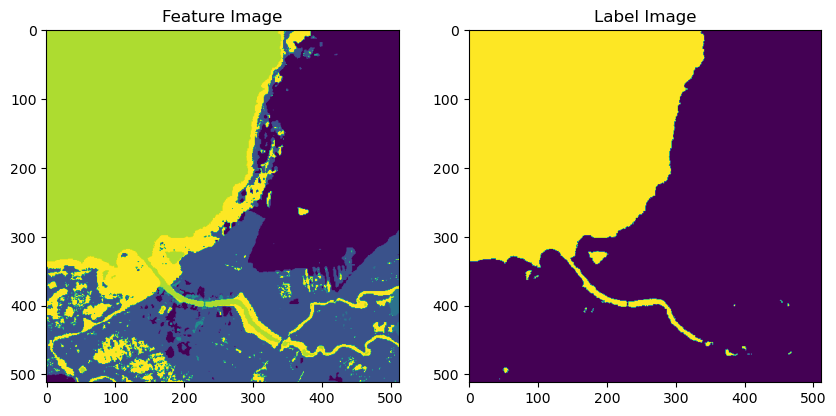

In [57]:
#display the feature and label images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(feature_img[4])
axes[0].set_title('Feature Image')
axes[1].imshow(label_img[0])
axes[1].set_title('Label Image')
plt.show()

In [58]:
val_img = np.moveaxis(feature_img, 0, -1)
val_img = val_img.reshape(-1, 6)

scaler = StandardScaler()
val_img_scale = scaler.fit_transform(val_img)  


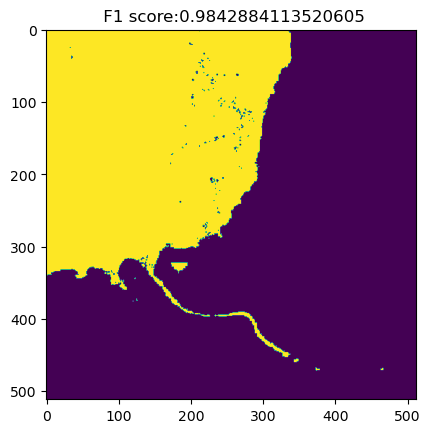

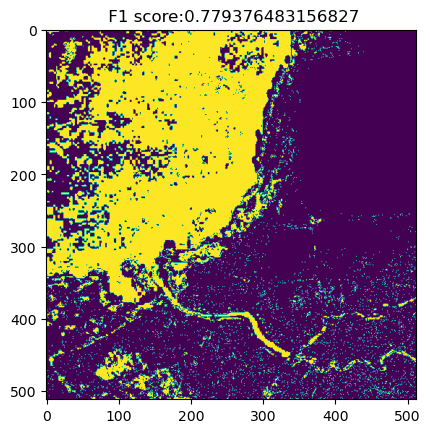

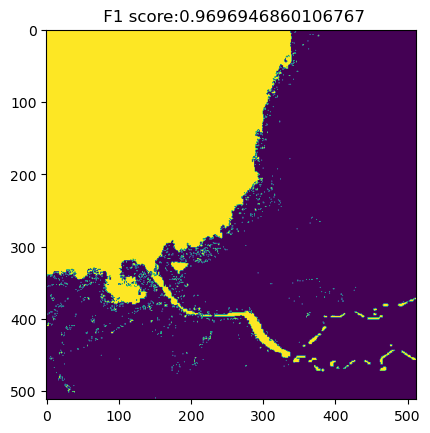

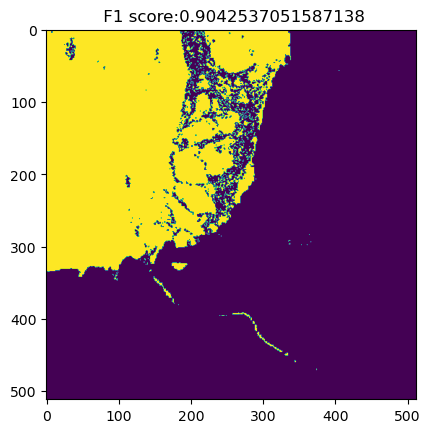

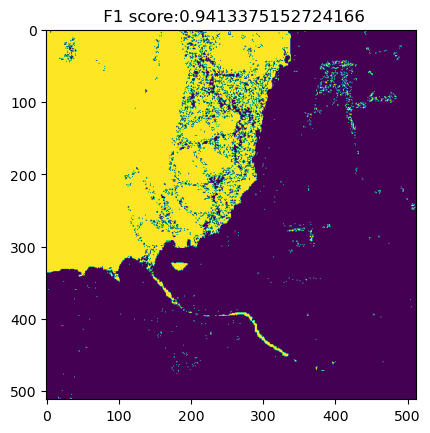

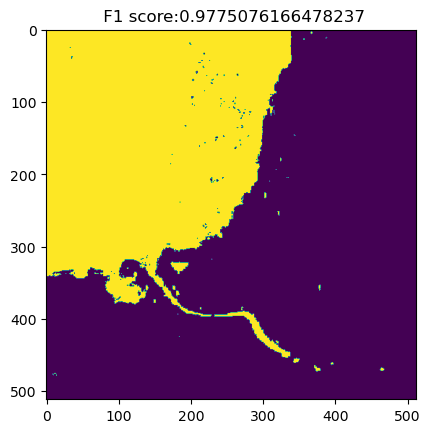

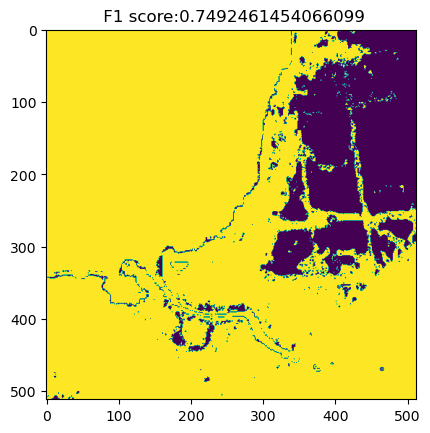

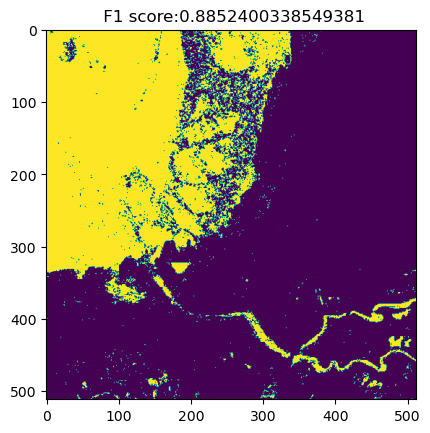

In [60]:
method_list = [logisticRegr,decisiontree,randomforest,svmothed,kneighbors,neuralnetwork,naivebayes,xgboostmethod]

from sklearn.metrics import f1_score

for index,item in enumerate(method_list):
    val_pre_img = item.predict(val_img_scale)
    #reshape the val image
    val_pre_img_reshape = val_pre_img.reshape(512,512)
    #set title
    #add the f1 score to the title
    plt.title( " F1 score:"+str(f1_score(label_img[0], val_pre_img_reshape, average='weighted')))
    #display the val image
    plt.imshow(val_pre_img_reshape)
    plt.show()

In [ ]:
#read all predic images
val_img_folder = "E:/Grss_data/Track1/val/images/"

In [ ]:
val_img_list = read_all_image(val_img_folder)

In [ ]:

val_feature_img = np.empty((0,6))
val_label_img = np.empty((0))
for val_img_path in val_img_list:
    #print(feature_img_path)
    val_img = rasterio.open(val_img_path)
    val_img = val_img.read()
    val_img = np.moveaxis(val_img, 0, -1)
    val_img = val_img.reshape(-1, 6)
    
    scaler = StandardScaler()
    val_img_scale = scaler.fit_transform(val_img)  
    val_feature_img=+val_img_scale

In [ ]:
val_feature_img

array([[-0.55509655, -0.34357563, -1.16975481, -1.02514714,  0.97554811,
         0.15565104],
       [ 0.36030629, -0.31652199, -1.16975481, -1.02514714,  0.97554811,
         0.15565104],
       [ 0.62945542, -0.81430884, -1.16975481, -1.02514714,  0.97554811,
         0.15565104],
       ...,
       [ 1.34225699,  0.28947938,  0.93015909,  0.70937356, -1.06560542,
        -0.12230603],
       [ 1.67795399, -0.07845002,  0.93015909,  0.6515562 , -1.06560542,
        -0.12230603],
       [ 1.192894  ,  0.42474755,  0.8523845 ,  0.59373884, -1.06560542,
        -0.12230603]])

In [ ]:
val_pre_img = clf.predict(val_feature_img)
val_pre_img

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
len(val_pre_img)

262144